# Plot diagrams


In [1]:
import matplotlib.pyplot as plt

In [2]:
# ResNet Random_19 (K=1): 0.07036247334754797
# ResNet Random_20 (K=1): 0.053304904051172705
# ResNet Random_21 (K=1): 0.07462686567164178
# ResNet ImageNet_v1 (K=1): 0.15565031982942432
# ResNet ImageNet_v2 (K=1): 0.10660980810234541
# ResNet PDDD (K=1): 0.18976545842217485

# Swin_T Random_19 (K=1): 0.06823027718550106
# Swin_T Random_20 (K=1): 0.0767590618336887
# Swin_T Random_21 (K=1): 0.05543710021321962
# Swin_T ImageNet (K=1): 0.39872068230277186
# Swin_T PDDD (K=1): 0.2579957356076759

# ResNet Random_19: 0.0021321961620469083
# ResNet Random_20: 0.01279317697228145
# ResNet Random_21: 0.008528784648187633 ???
# ResNet ImageNet_v1: 0.008528784648187633 ???
# ResNet ImageNet_v2: 0.07889125799573561
# ResNet PDDD: 0.14285714285714285

# Swin_T Random_19: 0.1023454157782516
# Swin_T Random_20: 0.10660980810234541
# Swin_T Random_21: 0.12366737739872068
# Swin_T ImageNet: 0.5778251599147122
# Swin_T PDDD: 0.3411513859275053

x_values_random = [
    "KNN ResNet50",
    "KNN ResNet50",
    "KNN ResNet50",
    "LogReg ResNet50",
    "LogReg ResNet50",
    "LogReg ResNet50",
    "KNN Swin-T",
    "KNN Swin-T",
    "KNN Swin-T",
    "LogReg Swin-T",
    "LogReg Swin-T",
    "LogReg Swin-T",
]
y_values_random = [
    0.07036247334754797,
    0.053304904051172705,
    0.07462686567164178,
    0.0021321961620469083,
    0.01279317697228145,
    0.008528784648187633,
    0.06823027718550106,
    0.0767590618336887,
    0.05543710021321962,
    0.1023454157782516,
    0.10660980810234541,
    0.12366737739872068,
]
x_values_imagenet = [
    "KNN ResNet50",
    "KNN ResNet50",
    "LogReg ResNet50",
    "LogReg ResNet50",
    "KNN Swin-T",
    "LogReg Swin-T",
]
y_values_imagenet = [
    0.15565031982942432,
    0.10660980810234541,
    0.008528784648187633,
    0.07889125799573561,
    0.39872068230277186,
    0.5778251599147122,
]
x_values_pddd = [
    "KNN ResNet50",
    "LogReg ResNet50",
    "KNN Swin-T",
    "LogReg Swin-T",
]
y_values_pddd = [
    0.18976545842217485,
    0.14285714285714285,
    0.2579957356076759,
    0.3411513859275053,
]

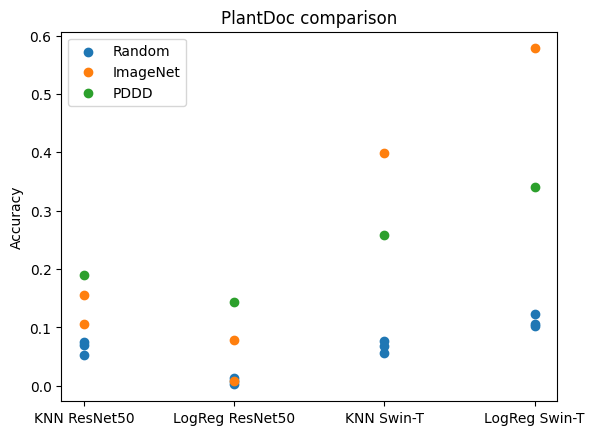

In [3]:
plt.scatter(x_values_random, y_values_random)
plt.scatter(x_values_imagenet, y_values_imagenet)
plt.scatter(x_values_pddd, y_values_pddd)
plt.gca().set_ylabel("Accuracy")  # gca = get current axes
plt.legend(["Random", "ImageNet", "PDDD"])
plt.title("PlantDoc comparison")
plt.show()

In [6]:
x_values_random = [
    "KNN ResNet50",
    "KNN ResNet50",
    "KNN ResNet50",
    "LogReg ResNet50",
    "LogReg ResNet50",
    "LogReg ResNet50",
    "KNN Swin-T",
    "KNN Swin-T",
    "KNN Swin-T",
    "LogReg Swin-T",
    "LogReg Swin-T",
    "LogReg Swin-T",
]
y_values_random = [
    0.446064139941691,
    0.43440233236151604,
    0.43440233236151604,
    0.2944606413994169,
    0.32653061224489793,
    0.40233236151603496,
    0.45481049562682213,
    0.36151603498542273,
    0.40233236151603496,
    0.5451895043731778,
    0.4752186588921283,
    0.4956268221574344,
]
x_values_imagenet = [
    "KNN ResNet50",
    "KNN ResNet50",
    "LogReg ResNet50",
    "LogReg ResNet50",
    "KNN Swin-T",
    "LogReg Swin-T",
]
y_values_imagenet = [
    0.5714285714285714,
    0.565597667638484,
    0.2565597667638484,
    0.4897959183673469,
    0.5830903790087464,
    0.7346938775510204,
]
x_values_pddd = [
    "KNN ResNet50",
    "LogReg ResNet50",
    "KNN Swin-T",
    "LogReg Swin-T",
]
y_values_pddd = [
    0.4752186588921283,
    0.42565597667638483,
    0.6122448979591837,
    0.6384839650145773,
]

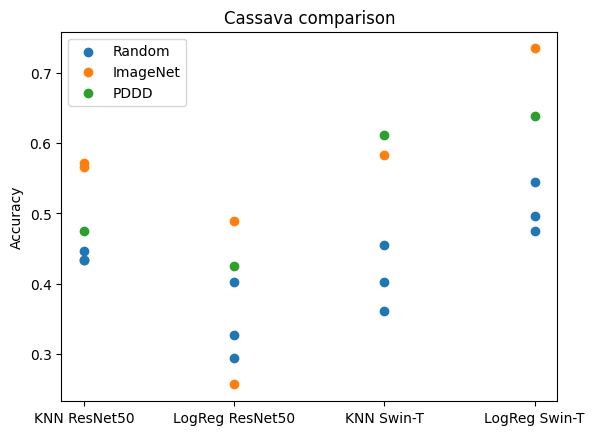

In [7]:
plt.scatter(x_values_random, y_values_random)
plt.scatter(x_values_imagenet, y_values_imagenet)
plt.scatter(x_values_pddd, y_values_pddd)
plt.gca().set_ylabel("Accuracy")  # gca = get current axes
plt.legend(["Random", "ImageNet", "PDDD"])
plt.title("Cassava comparison")
plt.show()